# Document Insights with Amazon Bedrock Data Automation: Foundation Building

This notebook begins your journey with Amazon Bedrock Data Automation (BDA) by establishing essential foundations for working with unstructured data. Document processing represents the cornerstone capability within BDA's multimodal toolkit - mastering document analysis provides you with patterns and techniques that extend to all other data modalities.

As you work through this notebook, you'll build a foundation for:
- Structuring unstructured document content
- Extracting valuable insights with generative AI
- Converting complex documents into application-ready formats
- Developing patterns that scale across document types

This notebook demonstrates how to use Amazon Bedrock Data Automation (BDA) to extract structured insights from documents. BDA provides a comprehensive solution for processing documents and extracting valuable information such as text, tables, figures, and metadata.

In this enhanced notebook, we'll focus on the core BDA workflow:
1. Preparing a sample document
2. Creating a BDA project with standard output configuration
3. Processing the document with BDA
4. Analyzing the results

The setup cell below contains helper functions and initialization code. **It's collapsed by default** - you can expand it to see the details, but you don't need to understand all of it to follow the main BDA workflow.

In [13]:
# This cell contains setup code and helper functions
# You can expand it to see the details, but you don't need to understand all of it.

import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Set environment variables to suppress pip warnings
os.environ['PIP_DISABLE_PIP_VERSION_CHECK'] = '1'
os.environ['PIP_NO_WARN_SCRIPT_LOCATION'] = '1'

# Hide pip installation messages
import subprocess
import sys

def install_packages(packages):
    for package in packages:
        try:
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", package, 
                "--quiet", 
                "--no-warn-script-location",
                "--disable-pip-version-check",
                "--no-warn-conflicts"
            ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        except subprocess.CalledProcessError:
            # If installation fails, continue with next package
            pass
    
# Install ALL dependencies needed for the entire workshop
install_packages([
    # Core AWS dependencies - with specific versions
    "boto3>=1.37.4,<1.38.0",
    "botocore>=1.37.4,<1.38.0",
    
    # Document handling
    "PyPDF2",
    
    # AWS services
    "sagemaker",
    
    # Data handling
    "pandas",
    "numpy",
    
    # Visualization
    "matplotlib",
    
    # Image processing
    "pillow",
    
    # Video processing
    "moviepy",
    
    # RAG dependencies
    "opensearch-py",
    
    # Utils
    "requests",
    "packaging",
    "retrying",
    "s3fs",
    "tqdm",
    
    # Interactive widgets
    "ipywidgets",
    
    # JSON handling
    "jsonschema"
])

# Add a force reinstall for boto3/botocore to ensure clean install
try:
    subprocess.check_call([
        sys.executable, 
        "-m", 
        "pip", 
        "install", 
        "--force-reinstall", 
        "boto3>=1.37.4,<1.38.0", 
        "botocore>=1.37.4,<1.38.0",
        "--quiet",
        "--disable-pip-version-check"
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
except subprocess.CalledProcessError:
    # Continue if reinstall fails
    pass

import boto3
import json
import pandas as pd
from IPython.display import JSON, display, IFrame, Markdown, HTML, Image
import sagemaker
import time
import requests
from pathlib import Path

# Import all utilities from the utils module
from utils.utils import BDAUtils, show_business_context, download_file, ensure_bda_results_dir

# Initialize our utility class and business context
bda_utils = BDAUtils()

# Display business context right after import
show_business_context("document_processing")

print("Setup complete. BDA utilities initialized.")


Bucket bda-workshop-us-west-2-033741858282 already exists



Amazon Bedrock Data Automation (BDA) enables you to extract structured information
from unstructured documents by leveraging generative AI to automate transformation into structured formats.

### Business Value

- **Automate Intelligent Document Processing (IDP)**: Process documents at scale without orchestrating complex 
  tasks like classification, extraction, normalization, or validation
- **Streamline Workflows**: Transform unstructured documents into business-specific, structured data that 
  integrates with existing systems
- **Accelerate Development**: Managed experience and customization capabilities help deliver business value faster
- **Reduce Complexity**: Eliminate the need to manage multiple AI models and services through a unified API-driven experience


Setup complete. BDA utilities initialized.


## Industry Applications

As you work through this notebook, consider how document processing could transform workflows in your specific domain:

**Financial Services**: How would automatic extraction from financial statements, invoices, and contracts change your operational workflows?

**Healthcare**: What opportunities would emerge if you could instantly structure and analyze medical records, insurance forms, and clinical notes?

**Legal**: How would your document review processes benefit from automated extraction of key clauses, obligations, and terms from legal documents?

**Manufacturing**: What if quality control reports, safety documentation, and compliance certificates could be automatically processed and analyzed?

**Your Industry**: What types of documents are most time-consuming for your organization to process manually? What insights within these documents would be most valuable to extract?

## 1. Prepare Sample Document

First, we'll download a sample document (Monthly Treasury Statement) and upload it to S3 for processing with BDA. This document contains financial information, tables, and figures that BDA can analyze.

The document will be stored in an S3 bucket that BDA can access. This is a required step as BDA needs to read the document from S3.

In [2]:
# Document URL and local path
document_url = "https://fiscaldata.treasury.gov/static-data/published-reports/mts/MonthlyTreasuryStatement_202411.pdf"
local_file_name = "samples/MonthlyTreasuryStatement_202411.pdf"

# Print bucket information
print(f"Using S3 bucket: {bda_utils.bucket_name}")
print(f"Input location: {bda_utils.input_location}")
print(f"Output location: {bda_utils.output_location}")

# Download the document with enhanced download function
os.makedirs(os.path.dirname(local_file_name), exist_ok=True)
local_path = download_file(document_url, local_file_name) or bda_utils.download_document(document_url, local_file_name)
print(f"Downloaded document to: {local_path}")

# Upload to S3
file_name = Path(local_path).name
document_s3_uri = f'{bda_utils.input_location}/{file_name}'
bda_utils.upload_to_s3(local_path, document_s3_uri)
print(f"Uploaded document to S3: {document_s3_uri}")

# Display the document (as a simple HTML element to avoid extra space)
display(HTML(f'<iframe src="{local_path}" width="800" height="600" style="border: none;"></iframe>'))

Using S3 bucket: bda-workshop-us-west-2-033741858282
Input location: s3://bda-workshop-us-west-2-033741858282/bda/input
Output location: s3://bda-workshop-us-west-2-033741858282/bda/output
Downloaded https://fiscaldata.treasury.gov/static-data/published-reports/mts/MonthlyTreasuryStatement_202411.pdf to samples/MonthlyTreasuryStatement_202411.pdf
Downloaded document to: samples/MonthlyTreasuryStatement_202411.pdf
Uploaded document to S3: s3://bda-workshop-us-west-2-033741858282/bda/input/MonthlyTreasuryStatement_202411.pdf


## 2. Define BDA Standard Output Configuration

Before creating a BDA project, we need to define the standard output configuration. This configuration determines what information BDA will extract from the document and how it will be formatted.

In [3]:
show_business_context("standard_output")

# Define standard output configuration for document processing
standard_output_config = {
  "document": {
    "extraction": {
      # Extract at document, page, and element levels
      "granularity": {"types": ["DOCUMENT", "PAGE", "ELEMENT"]},
      # Include bounding boxes for document elements
      "boundingBox": {"state": "ENABLED"}
    },
    # Enable AI-generated summaries and descriptions
    "generativeField": {"state": "ENABLED"},
    "outputFormat": {
      # Output text in markdown format
      "textFormat": {"types": ["MARKDOWN"]},
      # Generate additional files (text, CSV)
      "additionalFileFormat": {"state": "ENABLED"}
    }
  }
}

print("Standard output configuration defined with the following settings:")
print("- Granularity: Document, Page, Element")
print("- Bounding Boxes: Enabled")
print("- Generative Fields: Enabled (for summaries and descriptions)")
print("- Text Format: Markdown")
print("- Additional File Formats: Enabled")


Standard output is the default way of interacting with Amazon Bedrock Data Automation. 
The configuration you choose significantly impacts the quality and usefulness of extracted data.

### Key Configuration Options

- **Granularity Levels**: Control the detail level of extraction
  - **DOCUMENT**: Overall document analysis for summaries and classifications
  - **PAGE**: Page-level extraction for page-specific insights
  - **ELEMENT**: Identification of semantic elements like tables and figures
  - **LINE/WORD**: Detailed text positioning for precise extraction

- **Output Format Parameters**: Control format of extracted data
  - **JSON**: Default output format for all BDA API responses
  - **textFormat**: Additional output formats generated alongside JSON
    - **PLAIN_TEXT**: Simplified text-only version of content
    - **MARKDOWN**: Formatted text with structure and emphasis
    - **HTML**: Web-ready representation with document structure
    - **CSV**: Tabular data format for spreadsheet applications

- **Bounding Box**: When enabled, provides coordinates for document elements, critical for spatial understanding and reconstruction

- **Generative Fields**: AI-generated summaries and descriptions that provide contextual understanding

### Industry Applications

- **Financial Services**: Automated processing of financial statements, invoices, and contracts
- **Healthcare**: Information extraction from clinical notes, medical records, and insurance forms
- **Legal**: Analysis of contracts, legal briefs, and case documentation


Standard output configuration defined with the following settings:
- Granularity: Document, Page, Element
- Bounding Boxes: Enabled
- Generative Fields: Enabled (for summaries and descriptions)
- Text Format: Markdown
- Additional File Formats: Enabled


## 3. Create BDA Project

Now we'll create a BDA project with our standard output configuration. The project stores the configuration settings that will be used to process documents.

### Key Parameters for `create_data_automation_project` API:

- **projectName**: A unique name for the project
- **projectDescription**: A description of the project's purpose
- **projectStage**: The stage of the project (LIVE or DEVELOPMENT)
- **standardOutputConfiguration**: The configuration we defined earlier

The project ARN returned by this API will be used when invoking BDA to process documents.

In [4]:
# Display information about BDA Projects
show_business_context("project_architecture")

# Define project name
project_name = "document_insights_project"

# Delete project if it already exists
projects_existing = [project for project in bda_utils.bda_client.list_data_automation_projects()["projects"] 
                     if project["projectName"] == project_name]
if len(projects_existing) > 0:
    print(f"Deleting existing project: {projects_existing[0]['projectName']}")
    bda_utils.bda_client.delete_data_automation_project(projectArn=projects_existing[0]["projectArn"])
    time.sleep(1)

# Create a new BDA project
print(f"Creating BDA project: {project_name}")
response = bda_utils.bda_client.create_data_automation_project(
    projectName=project_name,
    projectDescription="Project for extracting insights from documents",
    projectStage='LIVE',  # Use 'LIVE' for production, 'DEVELOPMENT' for testing
    standardOutputConfiguration=standard_output_config
)

# Get the project ARN
project_arn = response["projectArn"]
print(f"Project ARN: {project_arn}")

# Wait for project creation to complete
status_response = bda_utils.wait_for_completion(
    get_status_function=bda_utils.bda_client.get_data_automation_project,
    status_kwargs={'projectArn': project_arn},
    completion_states=['COMPLETED'],
    error_states=['FAILED'],
    status_path_in_response='project.status',
    max_iterations=15,
    delay=10
)

# Display project details
if status_response['project']['status'] == 'COMPLETED':
    print("\nProject created successfully with the following details:")
    print(f"- Name: {status_response['project']['projectName']}")
    print(f"- ARN: {status_response['project']['projectArn']}")
    print(f"- Stage: {status_response['project']['projectStage']}")
    print(f"- Creation Time: {status_response['project']['creationTime']}")
else:
    print(f"Project creation failed with status: {status_response['project']['status']}")


Projects are a fundamental architectural component in Amazon Bedrock Data Automation. They serve several critical purposes:

1. **Configuration Reusability**: Projects store processing configurations that can be reused across multiple document processing jobs, ensuring consistent results.

2. **Workflow Separation**: Different projects can be created for different document types or processing needs, allowing for specialized processing pipelines.

3. **Versioning and Evolution**: Projects can be updated over time as your needs evolve, while maintaining backward compatibility with existing workflows.

4. **Access Control**: Projects can have specific IAM permissions, allowing you to control which teams or services can access specific document processing configurations.

5. **Cost Management**: By organizing processing jobs under projects, you can track and allocate costs to specific business initiatives or departments.

### Project Stages

Each project can have two stages:
- **LIVE**: Used for production processing of customer requests
- **DEVELOPMENT**: Used for testing and modification before promoting to LIVE

These stages represent BDA's built-in versioning mechanism, allowing you to safely evolve your processing configurations while maintaining production stability. The DEVELOPMENT stage is accessible only through the API (not the console) for testing changes before promoting them to production.

### Project Limits

- Up to 40 document blueprints can be attached to a single project
- Each project can have one standard output configuration per data type
- Project names must be unique within your account and region

In production environments, you would typically create different projects for different document types or processing requirements, each with its own optimized configuration.


Creating BDA project: document_insights_project
Project ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-project/2e1bfaf1472e
Current status: COMPLETED
Process completed with status: COMPLETED

Project created successfully with the following details:
- Name: document_insights_project
- ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-project/2e1bfaf1472e
- Stage: LIVE
- Creation Time: 2025-10-31 09:48:01.556000+00:00


## 4. Process Document with BDA

Now we'll use the `invoke_data_automation_async` API to process our document with BDA. This API starts an asynchronous job to analyze the document and extract insights based on our project configuration.

In [5]:
show_business_context("processing_pipeline")

# Invoke BDA to process the document
print(f"Processing document: {document_s3_uri}")
print(f"Results will be stored at: {bda_utils.output_location}")

# Call the invoke_data_automation_async API
response = bda_utils.bda_runtime_client.invoke_data_automation_async(
    # Specify the input document location
    inputConfiguration={
        's3Uri': document_s3_uri
    },
    # Specify where to store the results
    outputConfiguration={
        's3Uri': bda_utils.output_location
    },
    # Specify the project to use
    dataAutomationConfiguration={
        'dataAutomationProjectArn': project_arn,
        'stage': 'LIVE'  # Must match the project stage
    },
    # Specify the BDA profile to use
    dataAutomationProfileArn=f'arn:aws:bedrock:{bda_utils.current_region}:{bda_utils.account_id}:data-automation-profile/us.data-automation-v1'
)

# Get the invocation ARN
invocation_arn = response['invocationArn']
print(f"Invocation ARN: {invocation_arn}")

# Wait for processing to complete
status_response = bda_utils.wait_for_completion(
    get_status_function=bda_utils.bda_runtime_client.get_data_automation_status,
    status_kwargs={'invocationArn': invocation_arn},
    completion_states=['Success'],
    error_states=['ClientError', 'ServiceError'],
    status_path_in_response='status',
    max_iterations=15,
    delay=10
)

# Check if processing was successful
if status_response['status'] == 'Success':
    job_metadata_s3_location = status_response['outputConfiguration']['s3Uri']
    print(f"\nDocument processing completed successfully!")
    print(f"Job metadata location: {job_metadata_s3_location}")
else:
    print(f"\nDocument processing failed with status: {status_response['status']}")
    if 'error_message' in status_response:
        print(f"Error message: {status_response['error_message']}")


When you invoke Amazon Bedrock Data Automation, the service executes a sophisticated processing pipeline:

### Processing Steps

1. **Document Ingestion**: The system loads and preprocesses the document from S3
2. **Structure Analysis**: AI models identify the document's hierarchical structure and components
3. **Content Extraction**: Text, tables, figures, and other elements are extracted with spatial information
4. **Semantic Enrichment**: Generative AI creates summaries and descriptions of document content
5. **Result Formation**: All extracted data is assembled into the requested output formats

### Processing Configuration

- **Input Configuration**: Specify the S3 location of your document
- **Output Configuration**: Define where processed results should be stored
- **Data Automation Configuration**: Reference your project ARN and stage
- **dataAutomationProfileArn**: A reference parameter that identifies the processing profile to use

### Performance Considerations

- Processing time depends on document complexity, size, and requested granularity
- Multi-page documents with many elements take longer to process
- Typical processing times range from seconds to a few minutes for complex documents


Processing document: s3://bda-workshop-us-west-2-033741858282/bda/input/MonthlyTreasuryStatement_202411.pdf
Results will be stored at: s3://bda-workshop-us-west-2-033741858282/bda/output
Invocation ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-invocation/52ea252c-1b74-409f-b6e7-27a7eef79ba3
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: Success
Process completed with status: Success

Document processing completed successfully!
Job metadata location: s3://bda-workshop-us-west-2-033741858282/bda/output/52ea252c-1b74-409f-b6e7-27a7eef79ba3/job_metadata.json


## 5. Analyze BDA Results

Now we'll retrieve and analyze the results from BDA. We'll break this analysis into several focused sections:
1. Job metadata and overview
2. Document structure and statistics
3. Element extraction (tables, figures)
4. Saving and practical application of results

In [6]:
show_business_context("business_applications")

# Load job metadata
job_metadata = json.loads(bda_utils.read_s3_object(job_metadata_s3_location))

# Display job information
print("=== BDA Job Information ===")
print(f"Job ID: {job_metadata['job_id']}")
print(f"Job Status: {job_metadata['job_status']}")
print(f"Modality: {job_metadata['semantic_modality']}")

# Get standard output path
asset_id = 0
standard_output_path = next(item["segment_metadata"][0]["standard_output_path"] 
                            for item in job_metadata["output_metadata"] 
                            if item['asset_id'] == asset_id)
print(f"\nStandard output path: {standard_output_path}")

# Load standard output
standard_output = json.loads(bda_utils.read_s3_object(standard_output_path))


The structured data extracted by BDA enables various business applications that transform how organizations work with documents.

### Practical Applications

- **Automated Data Entry**: Extract key data points directly into business systems
- **Contract Analysis**: Identify key terms, obligations, and risks in legal documents
- **Financial Analysis**: Extract and analyze financial metrics from reports and statements
- **Compliance Verification**: Check document content against regulatory requirements
- **Enterprise Search**: Make document content searchable across the organization

### Industry-Specific Use Cases

- **Financial Services**: Automated processing of loan applications, SEC filings, and investment prospectuses
- **Healthcare**: Information extraction from medical records, insurance claims, and clinical trial documentation
- **Legal**: Analysis of contracts, case law, and regulatory documentation
- **Manufacturing**: Processing of quality control reports, supply chain documentation, and safety compliance

### Integration Patterns

- **API Integration**: Connect with CRM, ERP, and other business systems
- **Data Pipelines**: Feed extracted information into data lakes and warehouses
- **Workflow Automation**: Trigger business processes based on document content
- **Knowledge Bases**: Build searchable repositories of document information


=== BDA Job Information ===
Job ID: 52ea252c-1b74-409f-b6e7-27a7eef79ba3
Job Status: PROCESSED
Modality: DOCUMENT

Standard output path: s3://bda-workshop-us-west-2-033741858282/bda/output/52ea252c-1b74-409f-b6e7-27a7eef79ba3/0/standard_output/0/result.json


### 5.1 Document Structure and Statistics

Let's examine the document's structure, metadata, and overall statistics.

In [7]:
# Display document metadata
print("=== Document Metadata ===")
metadata = standard_output['metadata']
print(f"File name: {metadata.get('s3_key', 'N/A')}")
print(f"Page count: {metadata.get('number_of_pages', 'N/A')}")
print(f"File type: {metadata.get('file_type', 'N/A')}")

# Display document summary
print("\n=== Document Summary ===")
if "document" in standard_output and "summary" in standard_output["document"]:
    print(standard_output["document"]["summary"])
elif "document" in standard_output and "description" in standard_output["document"]:
    print(standard_output["document"]["description"])

# Display document statistics
print("\n=== Document Statistics ===")
if "document" in standard_output and "statistics" in standard_output["document"]:
    stats = standard_output["document"]["statistics"]
    for key, value in stats.items():
        print(f"{key}: {value}")

=== Document Metadata ===
File name: bda/input/MonthlyTreasuryStatement_202411.pdf
Page count: 40
File type: PDF

=== Document Summary ===
This document is the Monthly Treasury Statement of Receipts and Outlays of the United States Government for Fiscal Year 2025 through November 30, 2024. It provides a detailed summary of the government's financial activities, including receipts from various sources such as individual income taxes, corporation income taxes, and social insurance, as well as outlays for functions like national defense, health, and social security. The report highlights the surplus or deficit for each month and the cumulative figures for the fiscal year. It also includes data on the means of financing the deficit or disposing of the surplus, such as borrowing from the public and other means. The document is prepared by the Bureau of the Fiscal Service, Department of the Treasury, and is based on data from federal entities, disbursing officers, and Federal Reserve banks.


### 5.2 Element Extraction Analysis

Now let's examine the specific elements extracted from the document, such as tables and figures.

=== Elements Summary ===
TEXT: 167
FIGURE: 11
TABLE: 36

=== Sample Table ===
Title: 


|                                        |         |
|----------------------------------------|---------|
| Summary                                | Page 5  |
| Receipts                               | Page 10 |
| Outlays                                | Page 11 |
| Means of Financing                     | Page 25 |
| Receipts/Outlays by Month              | Page 35 |
| Federal Trust Funds/ Securities        | Page 37 |
| Receipts by Source/Outlays by Function | Page 38 |
| Explanatory Notes                      | Page 39 |


=== Sample Figure ===
Type: IMAGE
Caption: No caption
Figure image: s3://bda-workshop-us-west-2-033741858282/bda/output/52ea252c-1b74-409f-b6e7-27a7eef79ba3/0/standard_output/0/assets/9b04def2-a4df-423f-9b35-9469f0319bbc.png


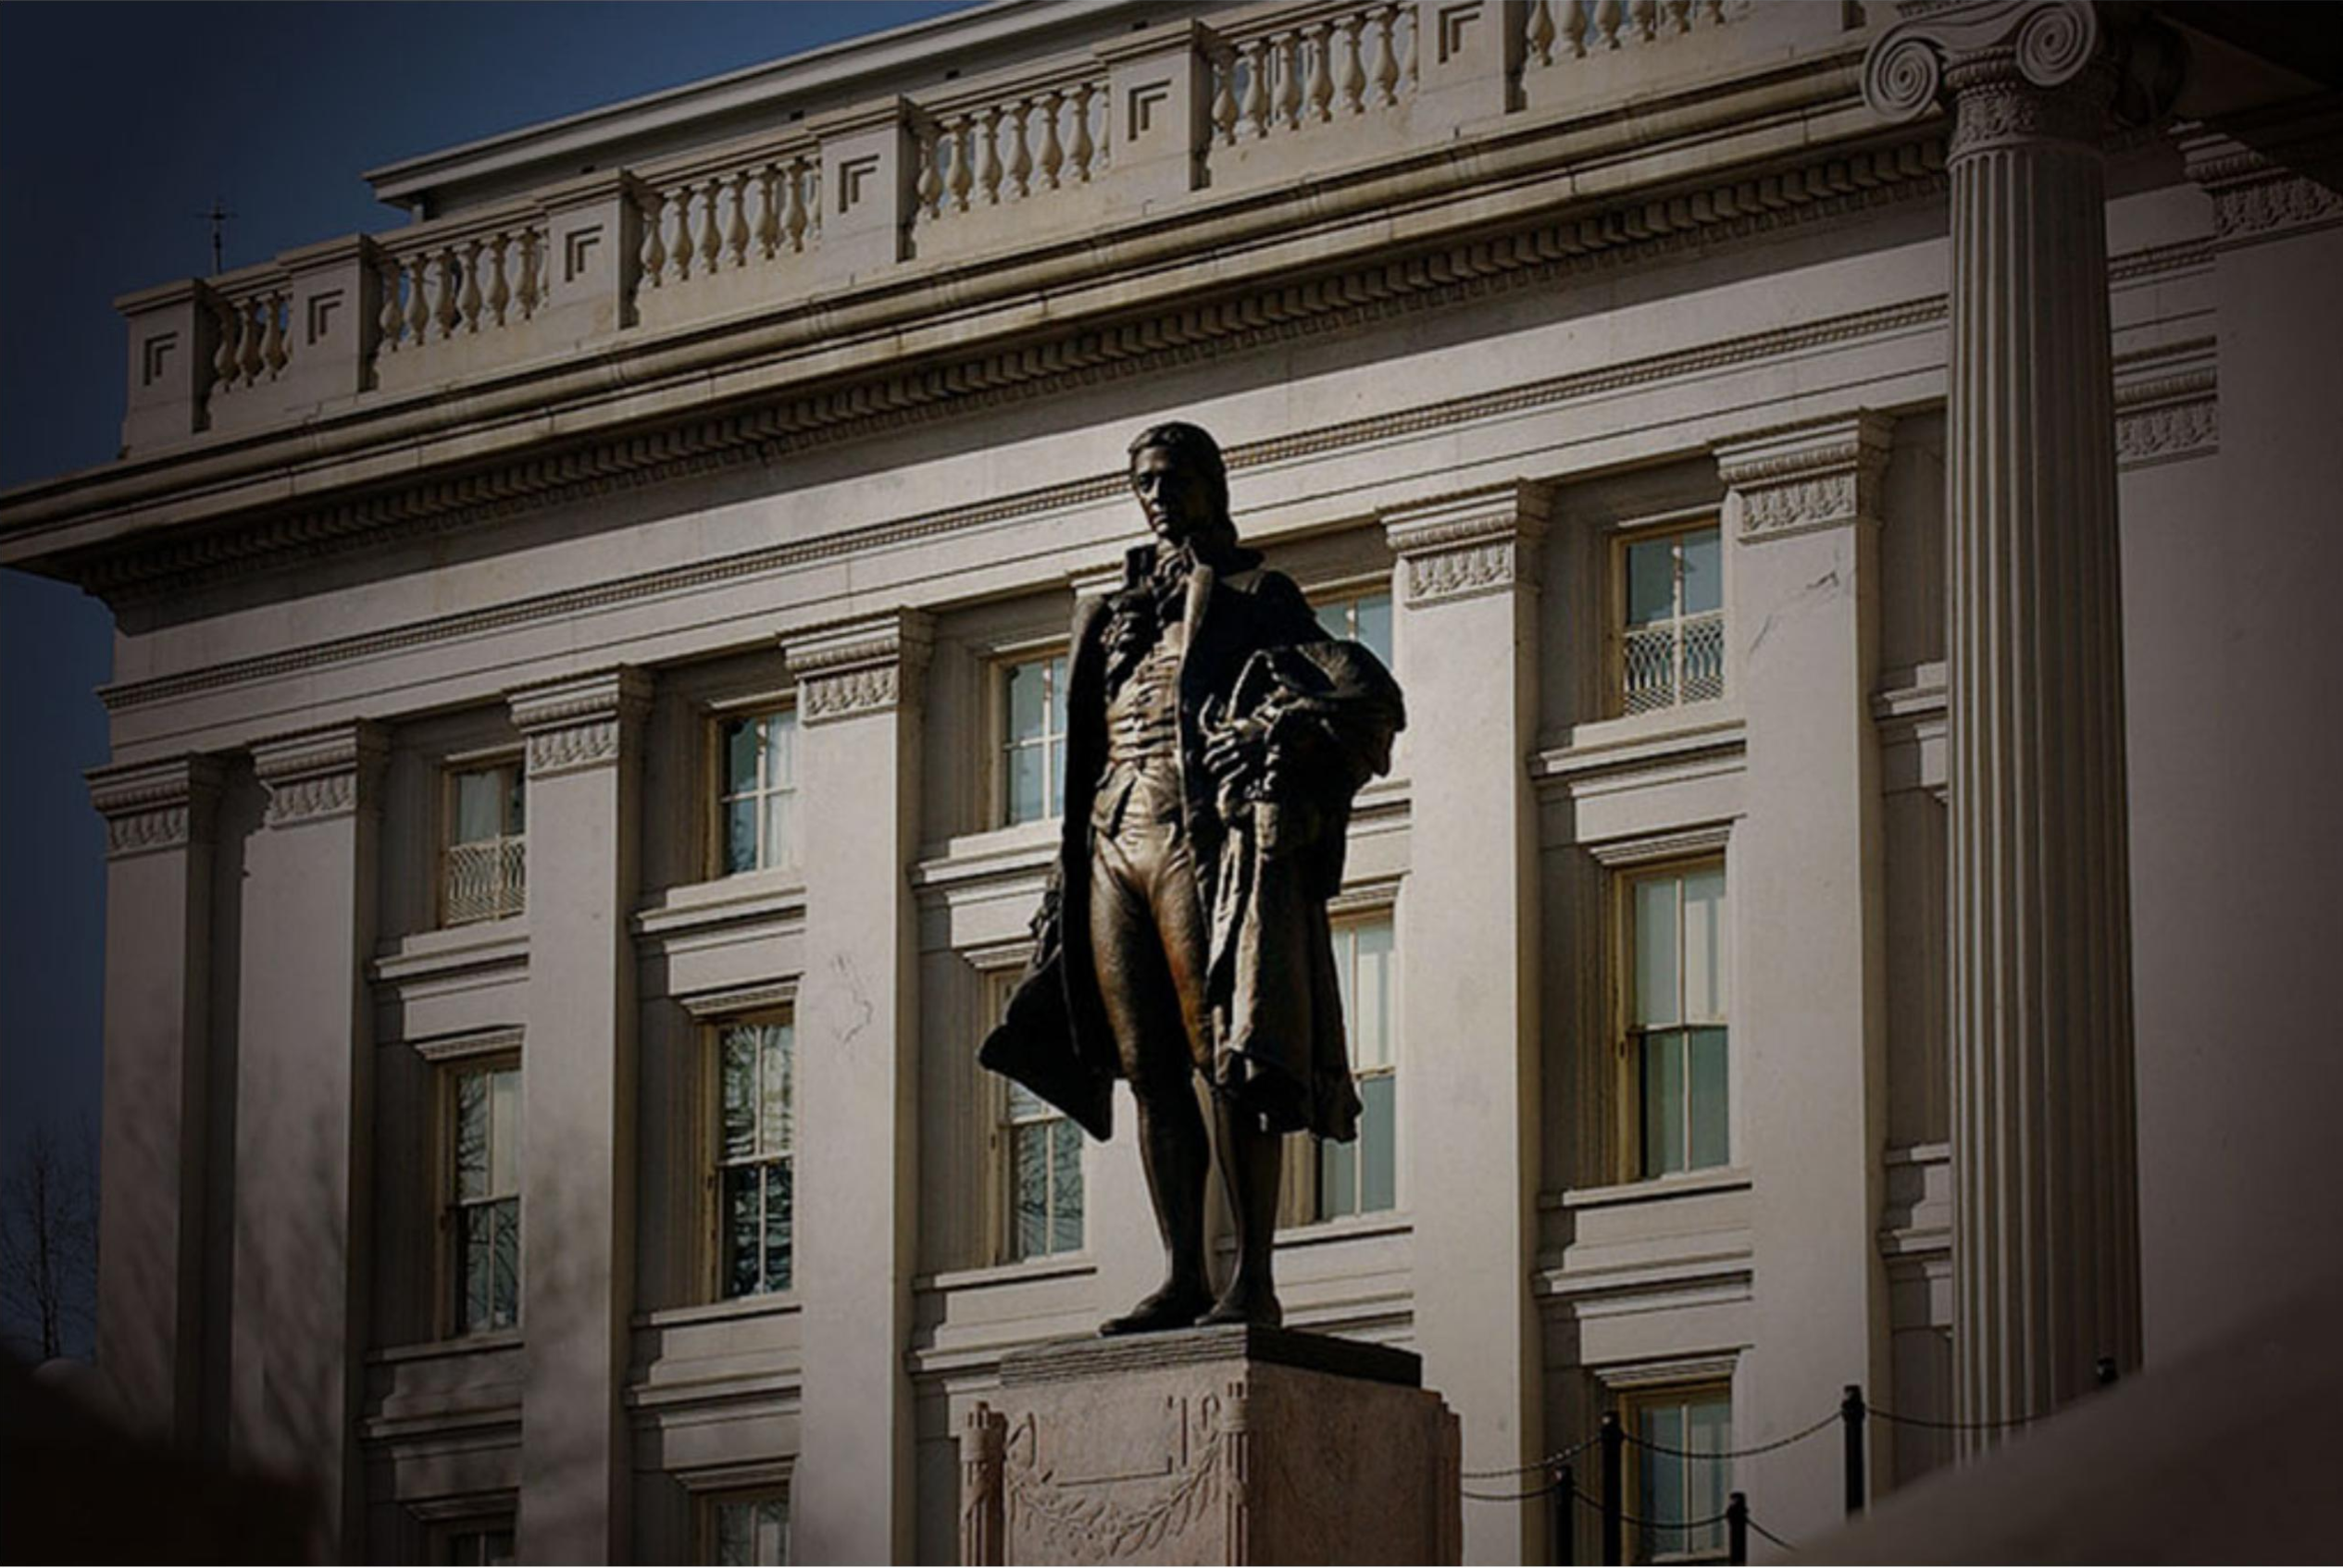

In [8]:
# Display elements summary
print("=== Elements Summary ===")
if "elements" in standard_output:
    elements = standard_output["elements"]
    element_types = {}
    for element in elements:
        element_type = element.get("type")
        if element_type:
            element_types[element_type] = element_types.get(element_type, 0) + 1
    
    for element_type, count in element_types.items():
        print(f"{element_type}: {count}")

# Display a sample table if available
tables = [element for element in standard_output.get("elements", []) if element.get("type") == "TABLE"]
if tables:
    print("\n=== Sample Table ===")
    table = tables[0]
    print(f"Title: {table.get('title', 'No title')}")
    if "representation" in table and "markdown" in table["representation"]:
        display(Markdown(table["representation"]["markdown"]))
    elif "representation" in table and "html" in table["representation"]:
        display(HTML(table["representation"]["html"]))

# Display a sample figure if available
figures = [element for element in standard_output.get("elements", []) if element.get("type") == "FIGURE"]
if figures:
    print("\n=== Sample Figure ===")
    figure = figures[0]
    print(f"Type: {figure.get('sub_type', 'Unknown')}")
    print(f"Caption: {figure.get('caption', 'No caption')}")
    if "crop_images" in figure and len(figure["crop_images"]) > 0:
        figure_s3_uri = figure["crop_images"][0]
        print(f"Figure image: {figure_s3_uri}")
        # Download and display the figure image
        display(bda_utils.download_and_display_figure(figure_s3_uri))

### 5.3 Practical Application of Results

Finally, let's save the results for practical application in downstream processes.

In [9]:
# Ensure bda-results directory exists and save results
ensure_bda_results_dir()

# Save the standard output to the bda-results directory
with open('../bda-results/document_result.json', 'w') as f:
    json.dump(standard_output, f)
    
print(f"Saved document results to: ../bda-results/document_result.json")
print("\nThese results can now be used for:")
print("- Data extraction pipelines")
print("- Integration with business systems")
print("- Input to machine learning models")
print("- Knowledge base creation")
print("- Enterprise search systems")

Ensured BDA results directory exists.
Saved document results to: ../bda-results/document_result.json

These results can now be used for:
- Data extraction pipelines
- Integration with business systems
- Input to machine learning models
- Knowledge base creation
- Enterprise search systems


## Understanding the Value of Structured Results

The structured JSON output provided by BDA represents a significant transformation of your unstructured document. Consider what you can now do with this data:

1. **Programmatic Access**: Every element in your document is now accessible via standard JSON parsing - no custom extraction logic needed
2. **Insight Generation**: The AI-generated descriptions provide contextual understanding beyond raw text extraction
3. **Relationship Mapping**: The hierarchical structure preserves relationships between document components
4. **Integration Ready**: This structured format is directly usable in databases, APIs, and analytics pipelines
5. **Decision Enablement**: Extracted facts and figures can now drive automated business processes

These capabilities represent a fundamental shift in how document content can be leveraged within applications.

## Summary

In this notebook, we demonstrated how to use Amazon Bedrock Data Automation (BDA) to extract structured insights from documents. We covered the key steps in the BDA workflow:

1. **Document Preparation**: Downloaded and uploaded a sample document to S3
2. **Configuration**: Defined a standard output configuration for document processing
3. **Project Creation**: Created a BDA project with our configuration using `create_data_automation_project`
4. **Document Processing**: Used the `invoke_data_automation_async` API to process the document
5. **Results Analysis**: Retrieved and analyzed the extracted insights

### Key BDA APIs Used:
- `create_data_automation_project`: Creates a project with configuration settings
- `invoke_data_automation_async`: Processes a document asynchronously
- `get_data_automation_status`: Checks the status of a processing job

### BDA Capabilities Demonstrated:
- Extracting text, tables, and figures from documents
- Generating summaries and descriptions
- Providing structured output in various formats
- Identifying document elements and their relationships

These capabilities can be used for various applications such as document understanding, information extraction, data preparation, and building document intelligence solutions.

For more information, see the [Amazon Bedrock Data Automation documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/data-automation.html).

## Your Journey with BDA

This document processing module establishes core patterns that will be consistent across all BDA modalities:
1. **Project Structure**: The project-based organization you've learned will apply to all content types
2. **Processing Pattern**: The asynchronous invocation pattern remains consistent across modalities
3. **Result Structure**: While specific fields differ, the hierarchical JSON result format is standardized
4. **Configuration Approach**: The configuration principles extend to image, audio, and video processing

As you progress through subsequent modules, you'll build upon these foundations to create a comprehensive multimodal data processing capability.

## Beyond Text: The Next Frontier

Text is just the beginning of what BDA can process. While document processing establishes the foundation, many real-world scenarios involve visual content that contains valuable information.

In the next module, we'll explore BDA's image analysis capabilities, where you'll learn how to:
- Extract insights from visual content like product images, diagrams, and graphics
- Analyze complex visual elements and their relationships
- Combine text and visual understanding for comprehensive insights

By extending your BDA skills from documents to images, you'll take the next step in building a complete multimodal data processing system.